In [1]:
import pickle

X_reduced, y_labels_weird = pickle.load(open("./X_reduced.pickle", "rb"))

In [2]:
import pandas
print("Before:", list(set(y_labels_weird)))
y_labels = y_labels_weird.apply(lambda x : x - 1)
print("After:", list(set(y_labels)))

Before: [1.0, 2.0, 3.0]
After: [0.0, 1.0, 2.0]


In [3]:
import tensorflow as tf

/Users/rajatrasal/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/rajatrasal/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
n_inputs = X_reduced.shape[1]
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 3

In [5]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [6]:
dropout_rate = 0.5

training = tf.placeholder_with_default(False, shape=(), name="training")


X_drop = tf.layers.dropout(X, dropout_rate, training=)

with tf.name_scope("NN"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [7]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [8]:
eta = 0.1
m = 0.9

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(eta, momentum=m, use_nesterov=True)
    training_op = optimizer.minimize(loss)

In [9]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [10]:
init = tf.global_variables_initializer()

In [20]:
from sklearn.model_selection import train_test_split

epochs = 6
batch_size = 100

with tf.Session() as sess:
    init.run()
    
    losses = []
    accuracies_val = []
    accuracies_training = []
    
    print(X_reduced.shape)
    print(y_labels.shape)
    
    for epoch in range(epochs):
        X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_labels, random_state=4, test_size=0.2)
        size = X_train.shape[0]
        for i in range(size // batch_size):
            split_slice = slice(i, min(size, i+batch_size), 1)
            X_train_batch = X_train[split_slice]
            y_train_batch = y_train[split_slice]
            sess.run(training_op, feed_dict={X: X_train_batch, y: y_train_batch})
        acc_train = accuracy.eval(feed_dict={X: X_train_batch, y: y_train_batch})
        acc_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
        l = sess.run(loss, feed_dict={X: X_test, y: y_test})
        losses.append(l)
        accuracies_val.append(acc_val)
        accuracies_training.append(acc_train)

(119906, 44)
(119906,)
[0.10885869, 0.048803467, 0.051727664, 0.049713533, 0.051960345, 0.054595094]
[0.9822367, 0.98736554, 0.9895755, 0.9902844, 0.9907014, 0.99095154]


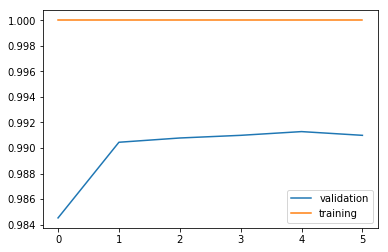

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(accuracies_val, label="validation")
plt.plot(accuracies_training, label="training")
plt.legend()